In [6]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
#from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils

from pipeline.python.utils import natural_keys, label_figure, convert_range, add_meta_to_df

from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse


from pipeline.python import utils as putils

from pipeline.python.retinotopy import segment_retinotopy as seg
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import colors as mcolors

In [2]:
%matplotlib notebook

In [3]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5
do_spherical_correction = False
rf_type = 'sphr' if do_spherical_correction else 'sq'

#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type, do_spherical_correction=do_spherical_correction)
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff


In [4]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, '%s-thr-%.2f' % (fit_desc, fit_thr)])

#### Filter RF datasets (no repeats)
filter_by = 'drop_repeats'
data_id = '%s|%s' % (data_id, filter_by)
print(data_id)

subdir = 'all_data' if filter_by is None else filter_by

print(data_id)
print(aggregate_dir)

traces001|fit-2dgaus_dff-no-cutoff-thr-0.50|drop_repeats
traces001|fit-2dgaus_dff-no-cutoff-thr-0.50|drop_repeats
/n/coxfs01/julianarhee/aggregate-visual-areas


# Load rfdf

In [7]:
# Get correctly assigned FOVs and cells (this includes NON-RFs):
sdata, cells0 = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state, return_cells=True,
                                visual_areas=['V1', 'Lm', 'Li'])
# Get subset of cells that are only RFs:
rf_dsets = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]
# rf_dsets = sdata[sdata['experiment']=='rfs10'].copy()

rf_dkeys = [(va, dk) for (va, dk), g in rf_dsets.groupby(['visual_area', 'datakey'])]
# assigned_cells = seg.get_cells_by_area(rf_dsets) # Same as below
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in rf_dkeys])

CELLS[['visual_area', 'animalid', 'session', 'fovnum']].drop_duplicates().groupby(['visual_area']).count()

Segmentation: missing 9 dsets


,animalid,session,fovnum
visual_area,,,
Li,17,17,17
Lm,18,18,18
V1,19,19,19


In [8]:
all_rfdfs = rfutils.aggregate_rfs(rf_dsets)
avg_rfs = aggr.get_rfdata(CELLS, all_rfdfs, verbose=False, average_repeats=False)
best_dfs = aggr.get_dsets_with_most_cells(avg_rfs) #, assigned_cells)
# best_dfs = aggr.get_dsets_with_max_rfs(rf_dsets, CELLS) # This does the above

N dpaths: 54, N unfit: 0
N datasets included: 62, N sessions excluded: 4
(u"ERROR, skipping (Li, JC091): ['20191007_JC091_fov1', '20191008_JC091_fov1']", Empty DataFrame
Columns: [visual_area, datakey, cell, animalid, fov, session]
Index: [])
[V1] Animalid does not exist: JC078 


In [9]:
# Get ALL data
rf_dpaths_all, no_fits_all = rfutils.get_fit_dpaths(rf_dsets, traceid=traceid, fit_desc=fit_desc)
len(rf_dpaths_all), len(no_fits_all)

N dpaths: 54, N unfit: 0
N datasets included: 62, N sessions excluded: 4


(62, 0)

In [10]:
# From selected list of analysis results, create aggr dataframe for RFs
allrfs = rfutils.aggregate_rf_data(rf_dpaths_all, assigned_cells=CELLS,
                                    fit_desc=fit_desc, traceid=traceid)
allrfs[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,16
Lm,16
V1,19


In [11]:
counts = allrfs.groupby(['experiment', 'visual_area', 'datakey'])['cell'].count().reset_index()

In [12]:
counts[counts.visual_area=='Lm'].sort_values(by='cell', ascending=False)

,experiment,visual_area,datakey,cell
7,rfs,Lm,20190508_JC083_fov1,70
13,rfs,Lm,20190603_JC080_fov1,57
9,rfs,Lm,20190512_JC083_fov1,43
12,rfs,Lm,20190525_JC084_fov1,38
4,rfs,Lm,20190430_JC078_fov1,36
6,rfs,Lm,20190506_JC080_fov1,32
49,rfs10,Lm,20190618_JC097_fov1,27
48,rfs10,Lm,20190602_JC080_fov2,23
11,rfs,Lm,20190517_JC083_fov1,19
10,rfs,Lm,20190513_JC078_fov1,19


In [111]:
va='Lm'
dk = '20190430_JC078_fov1'
rf_type = 'rfs'

# Test Receptive Fields

In [112]:
import matplotlib.gridspec as gridspec

def smooth_timecourse(in_trace, win_size=41):
    #smooth trace
    win_half = int(round(win_size/2))
    trace_pad = np.pad(in_trace, ((win_half, win_half)), 'reflect') # 'symmetric') #'edge')

    smooth_trace = np.convolve(trace_pad, np.ones((win_size,))*(1/float(win_size)),'valid')
    
    return smooth_trace

def smooth_traces_trial(gg, win_size=5, colname='trial'):
    smoothed_ = smooth_timecourse(gg, win_size=win_size)
    return pd.Series(smoothed_)
    

In [113]:
rows='ypos'
cols='xpos'

# Set output dirs
# -----------------------------------------------------------------------------
# rf_param_str = 'fit-2dgaus_%s-no-cutoff' % (response_type)
session, animalid, fovn = putils.split_datakey_str(dk)
fov = 'FOV%i_zoom2p0x' % fovn
traceid='traces001'
respsonse_type='dff'

exp_name = 'gratings' if int(session)<=20190511 else rf_type
rfdir, fit_desc = fitrf.create_rf_dir(animalid, session, fov,
                                'combined_%s_static' % exp_name, traceid=traceid,
                                response_type=response_type,
                                do_spherical_correction=do_spherical_correction, fit_thr=fit_thr)

data_id = '|'.join([animalid, session, fov, rf_type, traceid, fit_desc])
print(data_id)

JC078|20190430|FOV1_zoom2p0x|rfs|traces001|fit-2dgaus_dff-no-cutoff


In [114]:
# Fit results
print "... checking for existing fit results"
fit_results, fit_params = fitrf.load_fit_results(animalid, session, fov,
                            experiment=rf_type, traceid=traceid,
                            response_type=response_type,
                            do_spherical_correction=do_spherical_correction)

... checking for existing fit results


In [115]:
curr_rois = allrfs[(allrfs.visual_area==va) & (allrfs.datakey==dk) & (allrfs.experiment==rf_type)]['cell'].unique()

In [116]:
fit_thr=0.5
fitdf_all = fitrf.rfits_to_df(fit_results, scale_sigma=False, convert_coords=True,
                    fit_params=fit_params, spherical=do_spherical_correction,
                    row_vals=fit_params['row_vals'], col_vals=fit_params['col_vals'])

fitdf = fitdf_all.loc[curr_rois]
fit_roi_list = fitdf[fitdf['r2'] > fit_thr].sort_values('r2', axis=0, ascending=False).index.tolist()

In [117]:
fit_roi_list[0:10]

[213.0, 88.0, 106.0, 23.0, 282.0, 124.0, 48.0, 129.0, 211.0, 135.0]

In [118]:
# Set output dir
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 'example_plots')
if not os.path.isdir(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/example_plots


In [119]:
# Get data source
traceid_dir = rfdir.split('/receptive_fields/')[0]
data_fpath = os.path.join(traceid_dir, 'data_arrays', 'np_subtracted.npz')

trace_type='corrected'

# Load processed traces
raw_traces0, labels, sdf, run_info = fitrf.load_dataset(data_fpath,
                                            trace_type=trace_type,
                                            add_offset=True, make_equal=False,
                                            create_new=False)
raw_traces = raw_traces0[curr_rois].copy()
del raw_traces0

In [120]:
# Z-score or dff the traces:
trials_by_cond = fitrf.get_trials_by_cond(labels)
zscored_traces, zscores = fitrf.process_traces(raw_traces, labels,
                                        response_type=fit_params['response_type'],
                                        nframes_post_onset=fit_params['nframes_post_onset'])

--- processed traces: dff


In [121]:
# Get RFMAPS
avg_resp_by_cond0 = fitrf.load_rfmap_array(fit_params['rfdir'], do_spherical_correction=do_spherical_correction)
if avg_resp_by_cond0 is None:
    nx = len(fit_params['col_vals'])
    ny = len(fit_params['row_vals'])
    print("Error loading array, extracting now")
    print("...getting avg by cond")
    avg_resp_by_cond0 = fitrf.group_trial_values_by_cond(zscores, trials_by_cond, nx=nx, ny=ny,
                                                do_spherical_correction=do_spherical_correction)
    if do_spherical_correction:
        print("...doin spherical warps")
        if n_processes>1:
            avg_resp_by_cond0 = sphr_correct_maps_mp(avg_resp_by_cond0, fit_params,
                                                        n_processes=n_processes, test_subset=test_subset)
        else:
            avg_resp_by_cond0 = sphr_correct_maps(avg_resp_by_cond0, fit_params,
                                                        multiproc=False)
    print("...saved array")
    fitrf.save_rfmap_array(avg_resp_by_cond0, fit_params['rfdir'])
avg_resp_by_cond = avg_resp_by_cond0[curr_rois]         

Error loading array, extracting now
...getting avg by cond
...saved array


In [122]:
# Stim info
stim_on_frame = labels['stim_on_frame'].unique()[0]
nframes_on = labels['nframes_on'].unique()[0]
stim_on_sec = round(stim_on_frame/44.65, 1)

nframes_plot = fit_params['stim_on_frame'] + fit_params['nframes_on'] + fit_params['nframes_post_onset']
start_frame = fit_params['stim_on_frame'] #stim_on_frame #plot_start_frame #stim_on_frame #0
yunit_sec = round(fit_params['nframes_on']/fit_params['frame_rate'], 1)

# Add stim info to labels df for plotting
labels['xpos'] = sdf.loc[labels['config']]['xpos'].values
labels['ypos'] = sdf.loc[labels['config']]['ypos'].values

# position info
xpos = list(sorted(sdf['xpos'].unique()))
ypos = list(sorted(sdf['ypos'].unique()))

row_vals=fit_params['row_vals']
col_vals=fit_params['col_vals']

n_xpos = len(xpos)
n_ypos = len(ypos)

In [123]:
plot_ellipse=True
ellipse_ec='w'
ellipse_fc='none'
ellipse_lw=0.5
ellipse_alpha=1


fill_sem=True
mean_only=False
ls='-'
lw=0.5
legend_lw = 0.5

scale_sigma=True
sigma_scale=2.35
linecolor='darkslateblue'
cmap='bone'
legend_lw=0.25

nframes_plot = fit_params['stim_on_frame'] + fit_params['nframes_on'] #+ fit_params['nframes_post_onset']
start_frame = fit_params['stim_on_frame'] #stim_on_frame #plot_start_frame #stim_on_frame #0
yunit_sec = 0.5 #1.0 #round(fit_params['nframes_on']/fit_params['frame_rate'], 1)
yunit_frames = yunit_sec*44.65


In [124]:
if va=='Lm' and dk=='20190603_JC080_fov1':
    example_roi_list = [85, 128, 170]
else:
    example_roi_list = fit_roi_list[0:3]
example_roi_list

[213.0, 88.0, 106.0]

In [125]:
fit_roi_list[0:10]

[213.0, 88.0, 106.0, 23.0, 282.0, 124.0, 48.0, 129.0, 211.0, 135.0]

In [132]:
rid = 88
currt = labels.copy()
currt[response_type] = zscored_traces[rid].copy()

# Get curreent rf map
rfmap = np.flipud(avg_resp_by_cond[rid].reshape(len(row_vals), len(col_vals))) # fipud to match screen

<IPython.core.display.Javascript object>


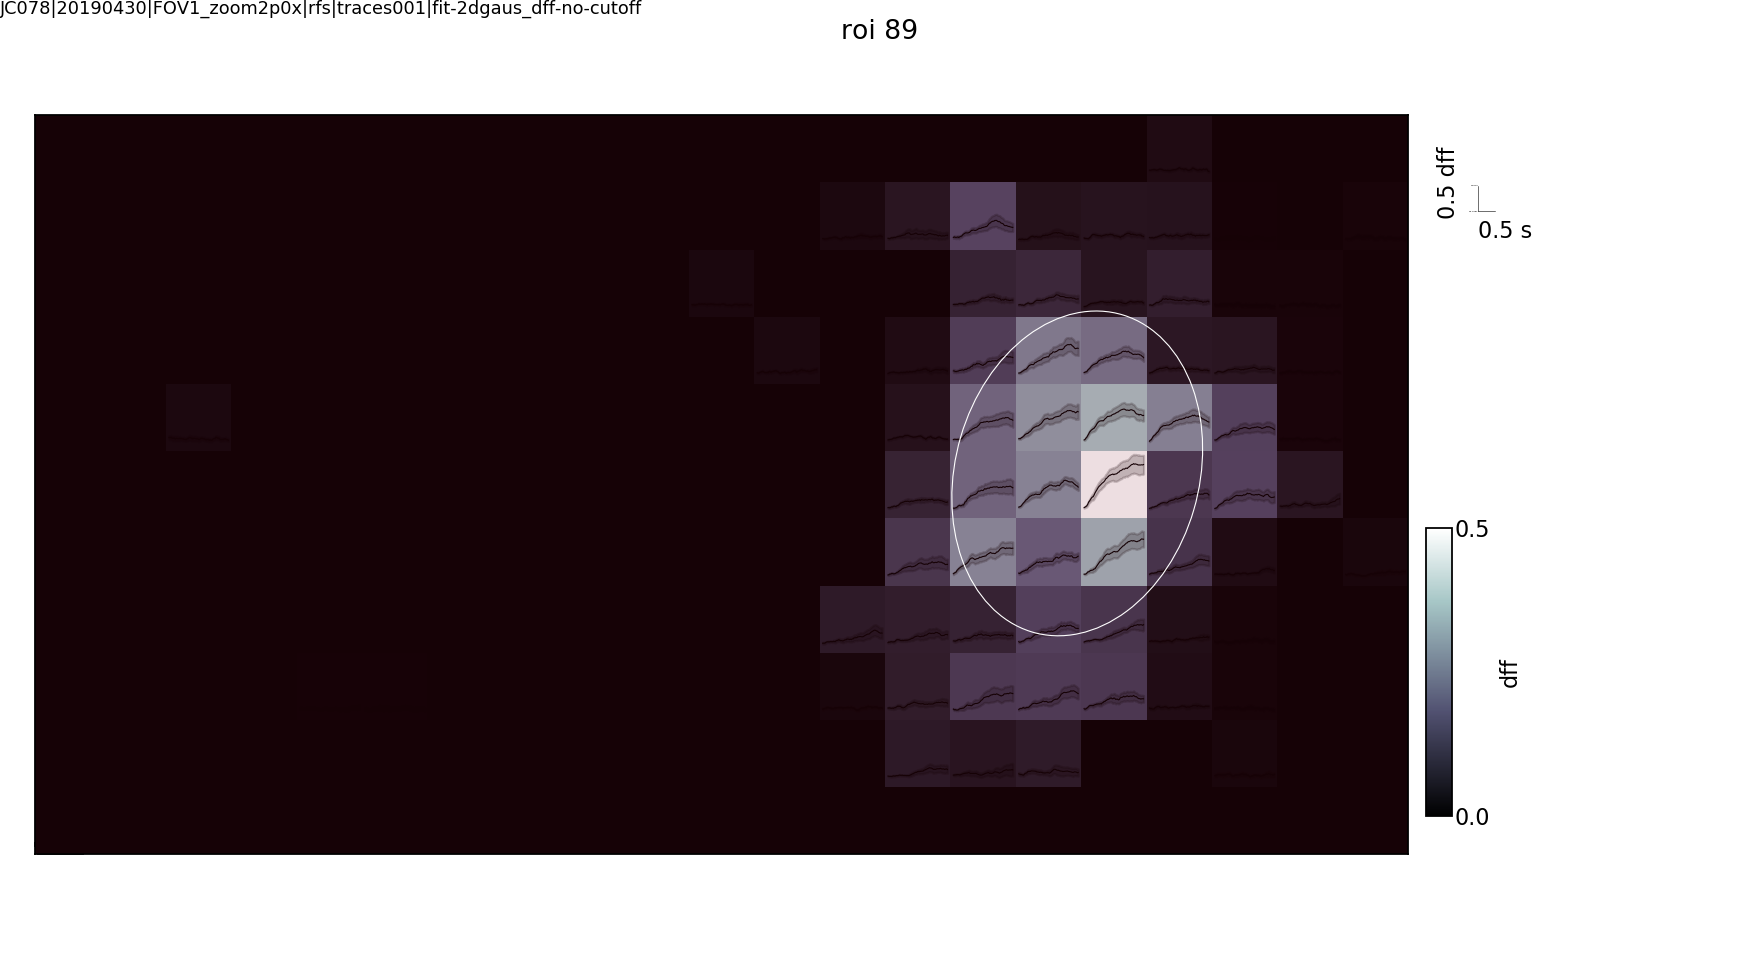

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/example_plots', 'Lm_20190430_JC078_fov1_roi00089_overlay')


In [133]:
vmin=0
vmax=0.5
set_ymax = 0.5

vmin = np.nanmin(rfmap) if vmin is None else vmin
vmax = np.nanmax(rfmap) if vmax is None else vmax
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmapper = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, axn = pl.subplots(n_ypos, n_xpos, figsize=(11, 6), sharex=True, sharey=True)
for (yp, xp), g in currt.groupby(['ypos', 'xpos']):
    yi = ypos[::-1].index(yp)
    xi = xpos.index(xp)
    ax=axn[yi, xi]
    #ax.set_title('%i, %i' % (xp, yp))
    ax.patch.set(alpha=1)
    pcolor = cmapper.to_rgba(rfmap[yi, xi])
    ax.patch.set_color(pcolor)

    t_df = g.groupby(['trial'])['dff'].apply(smooth_traces_trial, win_size=5).unstack().T
    mean_t = np.nanmean(t_df, axis=1)[start_frame:start_frame+nframes_plot]
    std_t = np.nanstd(t_df, axis=1)[start_frame:start_frame+nframes_plot]
    sem_t = spstats.sem(t_df, axis=1, nan_policy='omit')[start_frame:start_frame+nframes_plot]
    ax.fill_between(np.arange(0, len(mean_t)), mean_t-sem_t, mean_t+sem_t, alpha=0.2, color='k')
    ax.plot(mean_t, lw=lw, c='k', linestyle=ls) #, label='%s %i' % (hue_, curr_hue))
    # format
    if not (xi==0 and yi==len(ypos)-1):
        sns.despine(bottom=True, left=True, ax=ax)
    else:
        sns.despine(trim=True, ax=ax) #, bottom=True, left=True, ax=ax)
        
    ax.set_xticks([stim_on_frame, stim_on_frame+nframes_on])
    ax.tick_params(which='both', axis='both', size=0)
    ax.set_xticklabels([])
    ax.set_yticks([0.0, 0.1, 0.2])
    ax.set_yticklabels(['', '0.2 df/f', ''], rotation=90)
    ax.set_xlabel('') #''%s s' % (stim_on_sec))

# Set axis LIMITS
subplot_xlims = ax.get_xlim() 
subplot_ylims = ax.get_ylim() 

ax.set_ylim(subplot_ylims)
ax.set_xlim(subplot_xlims)

subplot_pos = ax.get_position()
for ax in axn.flat: #axes.flat:
    ax.set_ylim(subplot_ylims)
    ax.set_xlim(subplot_xlims)
    ax.tick_params(axis='both', which='both', length=0, labelsize=0)
    ax.set_xticks([])
    ax.set_yticks([])
    curr_pos = ax.get_position()
    new_pos = [curr_pos.x0, curr_pos.y0, subplot_pos.width, subplot_pos.height] #.1, .1]
    ax.set_position(new_pos)
pl.subplots_adjust(left=0.02, right=0.8, wspace=0, hspace=0)

if plot_ellipse:
    pos_ylim = (min(row_vals), max(row_vals))
    pos_xlim = (min(col_vals), max(col_vals))
    screen_xlim_centered = fitrf.get_centered_screen_points(pos_xlim, n_xpos)
    screen_ylim_centered = fitrf.get_centered_screen_points(pos_ylim, n_ypos)

    outergs = gridspec.GridSpec(1,1)
    outerax = fig.add_subplot(outergs[0])
    outerax.tick_params(axis='both', which='both', bottom=0, left=0,
                    labelbottom=0, labelleft=0)
    outerax.set_facecolor('crimson')
    outerax.patch.set_alpha(0.1)
    outerax = fig.add_subplot(outergs[0])
    outerax.set_ylim(screen_ylim_centered) #[screen_bottom, screen_top])
    outerax.set_xlim(screen_xlim_centered) #[screen_left, screen_right])
    
    ell = Ellipse((fitdf['x0'][rid], fitdf['y0'][rid]),
                    abs(fitdf['sigma_x'][rid])*sigma_scale,
                    abs(fitdf['sigma_y'][rid])*sigma_scale,
                    angle=np.rad2deg(fitdf['theta'][rid]))
    ell.set_alpha(ellipse_alpha)
    ell.set_edgecolor(ellipse_ec)
    ell.set_facecolor(ellipse_fc)
    ell.set_linewidth(ellipse_lw)
    outerax.add_patch(ell)


    # Add colorbar for RF map
    cmapper._A = []
    cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.3])
    cbar = fig.colorbar(cmapper, cax=cbar_ax)
    cbar.set_label('%s' % response_type)
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([round(vmin, 2), round(vmax, 2)])
    cbar.ax.tick_params(axis='both', which='both', length=0, pad=1)

    # Add legend for traces
    legend_pos = [0.84, 0.78, subplot_pos.width, subplot_pos.height] #.1, .1]
    leg = fig.add_subplot(111, position=legend_pos) #, aspect='auto')
    leg.clear()
    leg.plot(mean_t, 'w', alpha=1)
    leg.set_ylim(subplot_ylims)
    leg.set_xlim(subplot_xlims)
    ymax = ax.get_ylim()[-1] if set_ymax is None else set_ymax
    yscale = min([ymax, 2.0]) if response_type=='zscore' else min([ymax, 0.5])
    
    ymin, ymax = subplot_ylims
    leg.set_yticks([ymin, ymin+yscale])

    yunits = 'std' if response_type=='zscore' else response_type
    leg.set_ylabel('%.1f %s' % (yscale, yunits))

    xmin, xmax = subplot_xlims
    leg.set_xticks([xmin, xmin+yunit_frames])
    leg.set_xticklabels([])
    
    leg.tick_params(axis='both', which='both', size=0, labelsize=0, pad=0.01)
    for axlabel in ['left', 'bottom']:
        leg.spines[axlabel].set_linewidth(legend_lw)
    leg.set_xlabel('%.1f s' % yunit_sec, horizontalalignment='left', x=0)
    sns.despine(ax=leg, trim=True, offset=0) #, bottom=False)

    
label_figure(fig, data_id)
fig.suptitle('roi %i' % int(rid+1))
figname = '%s_%s_roi%05d_overlay' % (va, dk, int(rid+1))
pl.savefig(os.path.join(dst_dir, '%s.pdf' % (figname)), bboxx_inches='tight')
print(dst_dir, figname)

###### def plot_rfs_to_screen_pretty(fitdf, sdf, screen, sigma_scale=2.35, fit_roi_list=[], ax=None,
                             ellipse_lw=1, roi_colors=None):

    '''
    fitdf:  dataframe w/ converted fit params
    '''
    row_vals = sorted(sdf[rows].unique())
    col_vals = sorted(sdf[cols].unique())

    majors = np.array([np.abs(fitdf['sigma_x'][rid]*sigma_scale) for rid in fit_roi_list])
    minors = np.array([np.abs(fitdf['sigma_y'][rid]*sigma_scale) for rid in fit_roi_list])
    
    screen_left = -1*screen['azimuth_deg']/2.
    screen_right = screen['azimuth_deg']/2.
    screen_top = screen['altitude_deg']/2.
    screen_bottom = -1*screen['altitude_deg']/2.

    if ax is None:
        fig, ax = pl.subplots(figsize=(12, 6))
        fig.patch.set_visible(False) #(False) #('off')
    
    if roi_colors is None:
        roi_colors=sns.color_palette('bone', n_colors=len(fit_roi_list)+5) 
        #iter(cm.bone(np.linspace(0,1,len(fit_roi_list)+5)))
    for rid, rcolor in zip(fit_roi_list, roi_colors):
        #rcolor = next(rcolors)
        #ax.plot(fitdf['x0'][rid], fitdf['y0'][rid], marker='*', color=rcolor)
        ell = Ellipse((fitdf['x0'][rid], fitdf['y0'][rid]),
                      abs(fitdf['sigma_x'][rid])*sigma_scale, abs(fitdf['sigma_y'][rid])*sigma_scale,
                      angle=np.rad2deg(fitdf['theta'][rid]))

        ell.set_alpha(1.0)
        ell.set_linewidth(ellipse_lw)
        ell.set_edgecolor(rcolor)
        ell.set_facecolor('none')
        ax.add_patch(ell)

    ax.set_ylim([screen_bottom, screen_top])
    ax.set_xlim([screen_left, screen_right])
    ax.patch.set_color('gray')
    ax.patch.set_alpha(0.5)
    
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    #summary_str = "Avg sigma-x, -y: (%.2f, %.2f)\nAvg RF size: %.2f (min: %.2f, max: %.2f)" % (np.mean(majors), np.mean(minors), np.mean([np.mean(majors), np.mean(minors)]), avg_rfs.min(), avg_rfs.max())
    #pl.text(ax.get_xlim()[0]-12, ax.get_ylim()[0]-8, summary_str, ha='left', rotation=0, wrap=True)

    return ax


In [129]:
screen = fitrf.get_screen_dims()
screen

{'altitude_cm': 58.0,
 'altitude_deg': 67.323,
 'azimuth_cm': 103.0,
 'azimuth_deg': 119.5564,
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106),
 'resolution': [1920, 1080]}

In [100]:
1920/1080.

10/1.7

5.882352941176471

In [130]:
example_roi_list

[213.0, 88.0, 106.0]

<IPython.core.display.Javascript object>


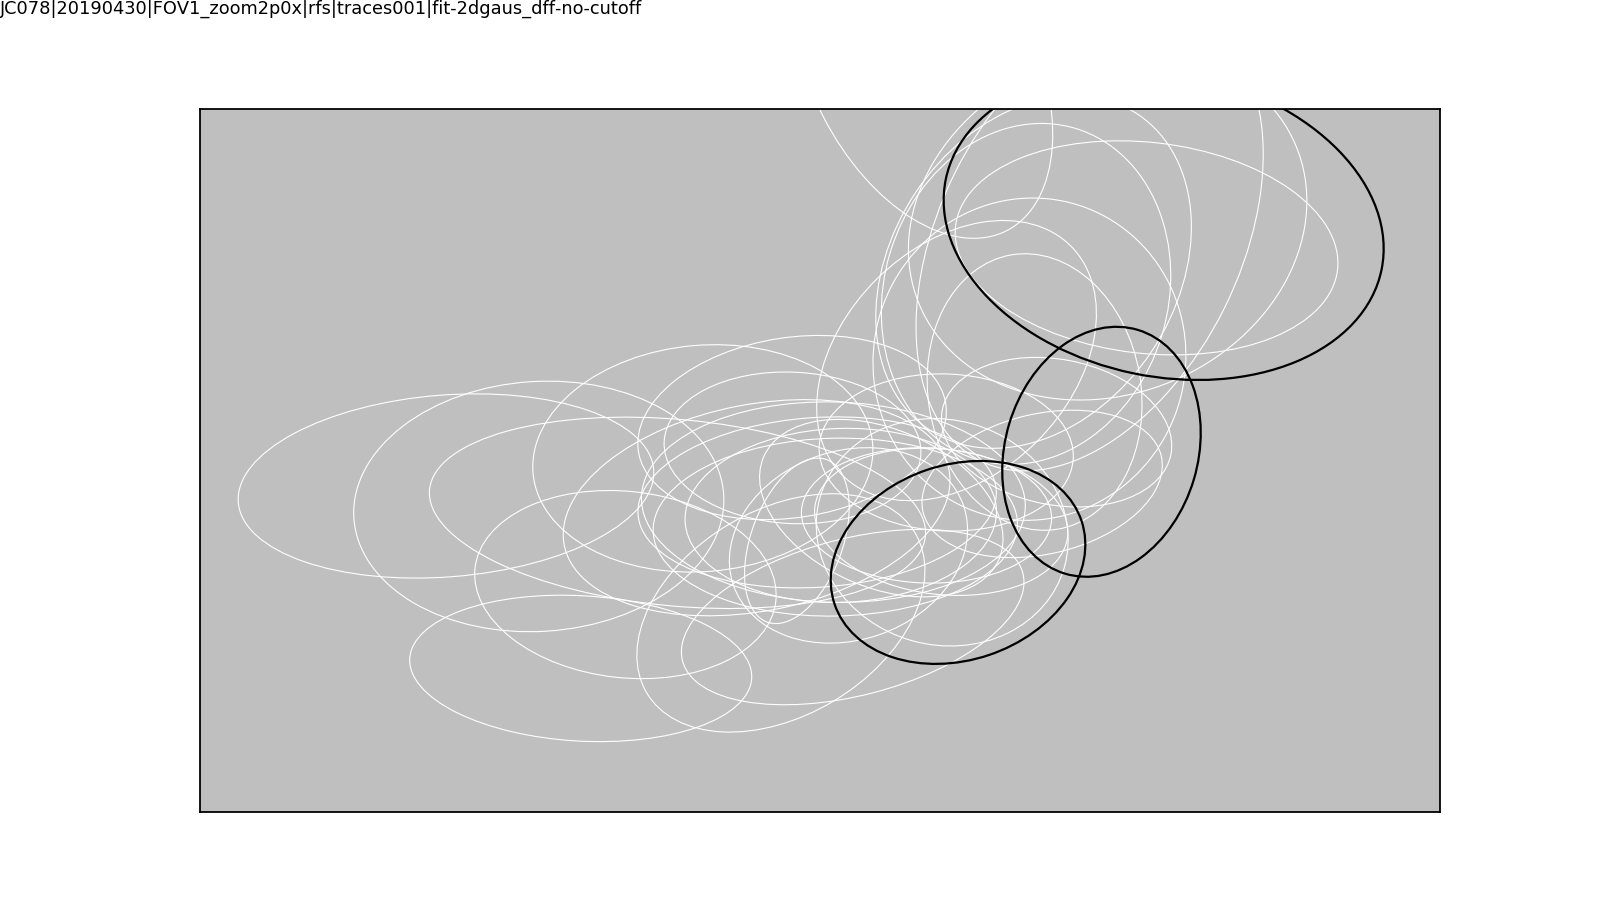

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/example_plots', 'Lm_20190430_JC078_fov1_all_rfs_in_fov')


In [131]:
fig, ax = pl.subplots(figsize=(10, 5.7))
fig.patch.set_visible(False) #(False) #('off')

other_rois = [r for r in fit_roi_list if r not in example_roi_list]
ax = plot_rfs_to_screen_pretty(fitdf, sdf, screen, sigma_scale=fit_params['sigma_scale'],
                               fit_roi_list=other_rois, ax=ax, 
                               roi_colors=['w']*len(other_rois), ellipse_lw=0.5)

ax = plot_rfs_to_screen_pretty(fitdf, sdf, screen, sigma_scale=fit_params['sigma_scale'],
                                fit_roi_list=example_roi_list, ax=ax, roi_colors=['k']*3, ellipse_lw=1)

putils.label_figure(fig, data_id)
figname = '%s_%s_all_rfs_in_fov' % (va, dk)
pl.savefig(os.path.join(dst_dir, '%s.pdf' % (figname)), bboxx_inches='tight')

print(dst_dir, figname)

In [134]:
best_rois_figdir

'/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_601a1c_traces001_e2ec1e_traces001_473e42_traces001_72c645_traces001_2a113f/receptive_fields/fit-2dgaus_dff-no-cutoff/nice_plots'

In [9]:
S = exc.Session(animalid, session, fov, rootdir=rootdir)

exp = exc.ReceptiveFields(animalid, session, fov, traceid=traceid, rootdir=rootdir)
exp.print_info()



[JC076] 20190420 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
... getting data paths
... combined_gratings_static
... renaming experiment to run name: combined_gratings_static
************* Experiment Object info *************
Name: combined_gratings_static
Experiment type: rfs
Animalid: JC076
Session: 20190420
FOV: FOV1_zoom2p0x
roi-id, trace-id: rois001, traces001
('Data source:', '/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_e280bf_traces001_113086_traces001_caa531_traces001_d04d75_traces001_5735eb/data_arrays/datasets.npz')
No data loaded yet.
**************************************************


In [10]:
exp.name

'combined_gratings_static'

In [8]:
estats = exp.get_stats(response_type=response_type)


... [combined_gratings_static] Loading roi stats and cell list...


IndexError: list index out of range

<IPython.core.display.Javascript object>


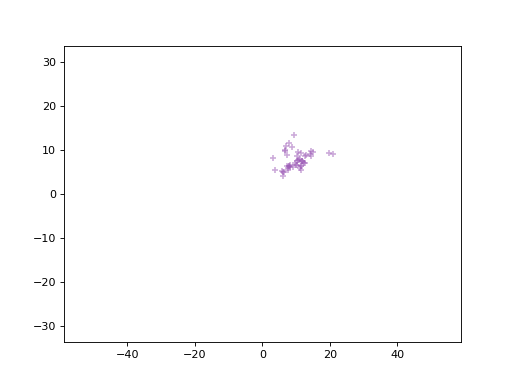

(-33.6615, 33.6615)

In [6]:

fig, ax = pl.subplots()
ax.scatter(estats.fits['sigma_x'], estats.fits['sigma_y'], marker='+', alpha=0.5)
ax.set_xlim([-S.screen['width']/2., S.screen['width']/2.])
ax.set_ylim([-S.screen['height']/2., S.screen['height']/2.])



In [9]:
exp.data.sdf

,aspect,direction,ori,position,sf,size,speed,stimtype,xpos,ypos
config001,1,0,0,"[-50, -25]",0.44,5,10,gratings,-50,-25
config002,1,0,0,"[-50, -20]",0.44,5,10,gratings,-50,-20
config003,1,0,0,"[-50, -15]",0.44,5,10,gratings,-50,-15
config004,1,0,0,"[-50, -10]",0.44,5,10,gratings,-50,-10
config005,1,0,0,"[-50, -5]",0.44,5,10,gratings,-50,-5
config006,1,0,0,"[-50, 0]",0.44,5,10,gratings,-50,0
config007,1,0,0,"[-50, 5]",0.44,5,10,gratings,-50,5
config008,1,0,0,"[-50, 10]",0.44,5,10,gratings,-50,10
config009,1,0,0,"[-50, 15]",0.44,5,10,gratings,-50,15
config010,1,0,0,"[-50, 20]",0.44,5,10,gratings,-50,20
